### Ajuste No-Lineal

In [ ]:
# Importo librerías
import numpy as np
import matplotlib.pyplot as plt
import time

***Suponiendo que quiero explicar la temperatura en función de los días del año***, una recta claramente no va a ser la mejor manera de ajustar esta relación. Por el contrario, el seno parece ser una buena forma (funcional) de ajustar mis observaciones.

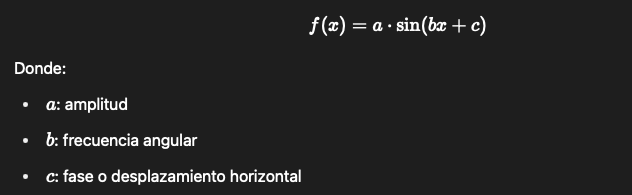

La idea es encontrar a, b y c tal que f(x) se parezca lo más posible a mis observaciones. Para esto, vamos a definir una función de error (o función de pérdida) que mida cuán diferentes son los valores predichos por f(x) y los valores observados y. En este caso, voy a utilizar el error cuadrático medio:

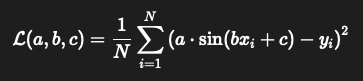

Esta función de pérdida depende de los tres parámetros a, b y c y mi objetivo es encontrar los valores óptimos que minimicen L. **Comienzo definiendo algunas funciones importantes:**

In [ ]:
# Defino la función a ajustar
def funcion_de_ajuste (x, params):
  a, b, c = params # A medida que vamos avanzando en complejidad de código vale la pena pasar los parámetros de la función todos juntos y así evitar errores
  return a * np.sin(b * x + c)

In [ ]:
# Defino la función de pérdida L (la que buscamos minimizar)
def funcion_loss (x, params, y):
  ''' MSE entre xi evaluado en la función de ajuste e yi'''
  predicciones = funcion_de_ajuste(x, params)
  return np.mean(np.square(predicciones - y)) # y son los valores reales (observaciones)

Para minimizar L(a, b, c) usando descenso por gradiente (gradient descent), necesito calcular el gradiente de la pérdida con respecto a cada uno de los parámetros.

Es decir, quiero saber:

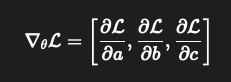

**Este vector me indica en qué dirección modificar cada parámetro para reducir el error.**

In [ ]:
# Defino la función gradiente del costo
def funcion_gradiente(x, params, y):
  predicciones = funcion_de_ajuste(x, params)
  a, b, c = params
  dl_a = 2 * np.mean((predicciones - y) * np.sin(b * x + c))
  dl_b = 2 * np.mean((predicciones - y) * np.cos(b * x + c) * x)
  dl_c = 2 * np.mean((predicciones - y) * np.cos(b * x + c))
  return np.array([dl_a,
                  dl_b,
                  dl_c])

Ahora que tengo listas mis funciones principales, defino la función de mi optimizador. **En este caso voy a usar descenso por gradiente estocástico (SGD).**

In [ ]:
# Defino la función de mi optimizador
def entrenar_seno_sgd(init_params,
                      x_data,
                      y_data,
                      funcion_gradiente,
                      funcion_loss,
                      n_epoches,
                      alpha,
                      n_minibatch,
                      tolerancia,
                      imprimir):

    """
    Entrena una función seno f(x) = a * sin(bx + c) usando descenso por gradiente estocástico.

    Parámetros:
    - x_data: array de inputs (por ejemplo, días del año)
    - y_data: array de observaciones (por ejemplo, temperatura)
    - funcion_gradiente: función que devuelve el gradiente ∇L respecto a [a, b, c]
    - funcion_loss: función que evalúa la pérdida (por ejemplo, MSE)
    - n_epoches: cantidad de épocas totales
    - alpha: tasa de aprendizaje
    - n_minibatch: tamaño del mini-batch (1 = SGD puro)
    - tolerancia: norma mínima del gradiente para detener el algoritmo
    - imprimir: si es True, imprime info de convergencia

    Devuelve:
    - params: parámetros finales [a, b, c]
    - historia: lista con la trayectoria de parámetros
    - loss_hist: lista con el valor de la pérdida en cada época
    """

    # Inicializo
    params = init_params # Es muy importante de que manera definimos los parámetros iniciales, y lo vamos a ver más adelante
    historia = [params.copy()]
    loss_hist = []

    # En primera instancia recorro las épocas
    for i in range(n_epoches):

        # Gradiente total sobre todas las muestras (para corte por tolerancia)
        grad_total = funcion_gradiente(x_data, params, y_data)

        if np.linalg.norm(grad_total) <= tolerancia:
            if imprimir == True:
                print(f'La función converge en {i} épocas.')
                print(f'Parámetros finales: {np.round(params, 4)}')
            break

        # La idea es desordenar las muestras cada vez que arranco a correr una nueva época para asegurar una convergencia más estable
        idx = np.random.permutation(len(x_data)) # Genero un array de índices del tamaño de x, pero en orden aleatorio

        # Ahora recorro todas las muestras, de a minibatches de tamaño n_minibatch
        for minibatch in range(0, len(x_data), n_minibatch):

            # Tomo los índices correspondientes a este mini-batch
            batch_idx = idx[minibatch : minibatch + n_minibatch]

            # Selecciono las filas de x e y que me corresponden en este mini-batch
            x_batch = x_data[batch_idx]
            y_batch = y_data[batch_idx]

            # Calculo el gradiente sobre este mini-batch
            grad = funcion_gradiente(x_batch, params, y_batch)

            # Actualizo los parámetros
            params = params - alpha * grad

            # Guardo historial de parámetros
            historia.append(params.copy())

        # Calculo y guardo pérdida global al final de cada época
        loss = funcion_loss(x_data, params, y_data)
        loss_hist.append(loss)

    return params, historia, loss_hist

Ahora sí voy a resolver el problema:

In [ ]:
# Datos sintéticos que quiero ajustar
x = np.linspace(np.pi/4, (3/2)*np.pi, num = 50)
y = np.sin(2.7 * x - 0.1)

In [ ]:
# Entrenamiento usando mi función
# init_params = np.array([0.8, 3.0, 1.0])  # Inicialización arbitraria
init_params = np.array([0.8, 0.1, 1.0]) # El otro punto propuesto en clase
t0 = time.time()

params, historia, loss_hist = entrenar_seno_sgd(
    init_params = init_params,
    x_data = x,
    y_data = y,
    funcion_gradiente = funcion_gradiente,
    funcion_loss = funcion_loss,
    n_epoches = 5000,
    alpha = 1e-2,
    n_minibatch = 10,
    tolerancia = 1e-8,
    imprimir = False
)

print("Tiempo de entrenamiento:", round(time.time() - t0, 2), "segundos")

Tiempo de entrenamiento: 1.85 segundos


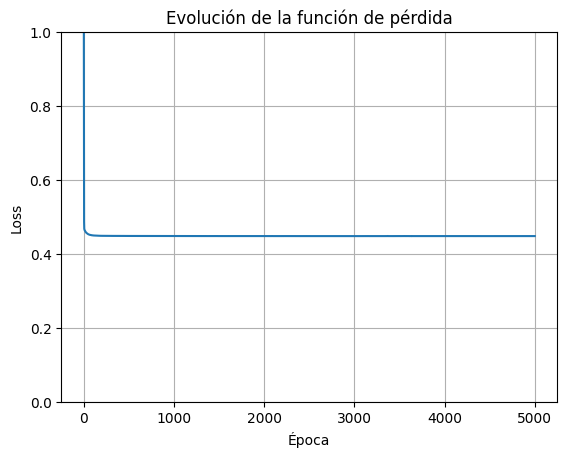

In [ ]:
# Grafico la evolución del error (la idea es que converga a cero)
plt.plot(loss_hist)
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolución de la función de pérdida')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

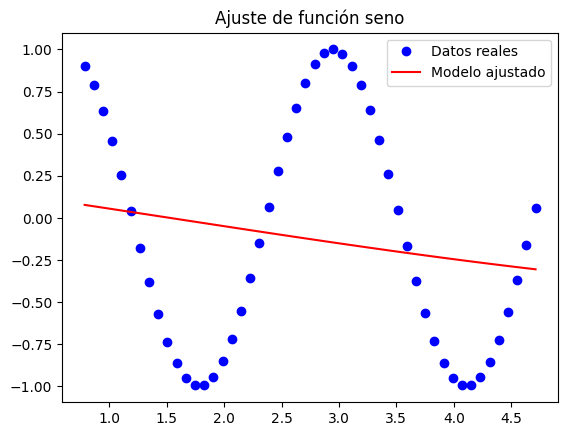

Parámetros aprendidos: [ 0.4686 -0.2228  0.3399]


In [ ]:
# Grafico el resultado final del modelo
plt.plot(x, y, 'bo', label = 'Datos reales')
plt.plot(x, funcion_de_ajuste(x, params), 'r-', label = 'Modelo ajustado')
plt.title('Ajuste de función seno')
plt.legend()
plt.show()

print("Parámetros aprendidos:", np.round(params, 4))

Cuando el valor inicial de b (frecuencia) es muy bajo, como el probado en el segundo punto de inicialización (b = 0.1), el modelo ajusta mal porque la función seno varía muy poco en el rango observado, pareciéndose a una recta. Esto genera gradientes muy pequeños y puede hacer que el optimizador quede atrapado en un mínimo local, lejos de la solución real. Este ejemplo muestra cómo, en problemas no lineales, una mala inicialización puede llevarnos a regiones planas o subóptimas de la función de pérdida. Para evitarlo, conviene probar diferentes puntos de partida o usar optimizadores más robustos como Adam o con momentum, que ayudan a escapar de estos mínimos locales.

**Le pregunté al chat GPT como se relacionan el tipo de ejercicio que hacíamos antes (Rosenbrock) con este nuevo tipo de ejercicio en donde optimizamos parámetros de una función como para ordenar mi cabeza.**

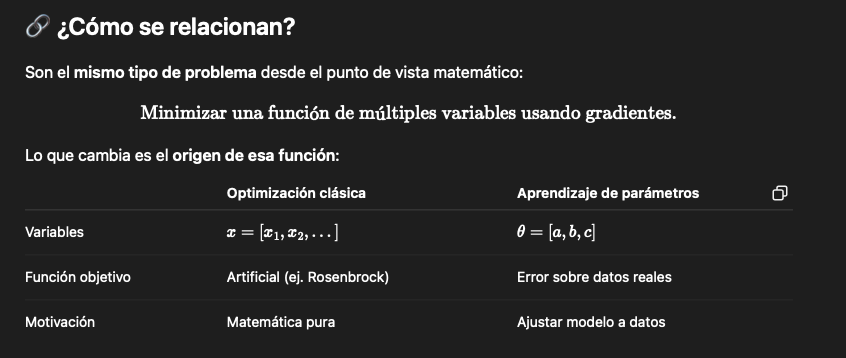

### Una Primera Red Neuronal

Ahora voy a probar ajustar una función cuadrática, pero utilizando una red neuronal. La red está dada por una concatenación de capas:

$$ h = \sigma (W x + b)$$

Las matrices $W$ y los vectores $b$ los voy a guardar en un solo vector, así es mas fácil implementar el optimizador.

In [ ]:
# Importo librerías
from jax import grad, jit
from jax import random
from jax import nn
from jax import vmap
import jax

In [ ]:
# Importo jax.numpy, que es el análogo de NumPy optimizado para JAX y matplotlib para visualizar los datos y el ajuste
import jax.numpy as jnp
import matplotlib.pyplot as plt

Lo primero que hacemos es definir la arquitectura de la red, que en este caso va a tener una única capa oculta compuesta de 64 neuronas.

In [ ]:
# Defino layer sizes
layer_sizes = [1, 64, 1]

Ahora defino dos funciones muy útiles para la inicialización de la red. Estas funciones se usan solo al inicio, para prender la red con valores aleatorios.

* random_layer_params --> crea los pesos y sesgos de UNA capa
* init_network_params --> aplica eso a TODA la red (capa por capa)

Esto le da a cada neurona un punto de partida para empezar a aprender. Después, estos valores se van ajustando con gradiente descendente y no se vuelven a usar.

In [ ]:
def random_layer_params(m, n, key, scale=1e-2):
    """

    Genera pesos y biases aleatorios para una sola capa.
      m: cantidad de entradas a la capa
      n: cantidad de neuronas (salidas) en la capa
      key: semilla aleatoria de JAX para reproducibilidad

    """
    # Divido la semilla original en dos: una para pesos, otra para biases
    w_key, b_key = random.split(key)

    # Escala basada en He initialization (mejor para activaciones tipo ReLU o ELU)
    scale = jnp.sqrt(2.0 / (m + n))  # ayuda a evitar saturación o explosión de activaciones

    # Genero matriz de pesos aleatorios con shape (n, m) → 1 fila por neurona, 1 columna por input
    W = scale * random.normal(w_key, (n, m))

    # Genero vector de biases aleatorios con shape (n,) → 1 bias por neurona
    b = scale * random.normal(b_key, (n,))

    return W, b

In [ ]:
def init_network_params(sizes, key):
    """

    Inicializa todos los pesos y biases de la red completa, capa por capa.

    """
    # Divide la semilla original en N claves independientes (una por capa)
    keys = random.split(key, len(sizes))  # ej: si hay 3 capas, da 3 claves

    # Aplica random_layer_params a cada par de capas consecutivas
    # sizes[:-1] = [input, ocultas]
    # sizes[1:]  = [ocultas, salida]
    # zip() junta cada (m, n) y la clave correspondiente
    return [random_layer_params(m, n, k)
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

Voy a trabajarlo a mi manera, y como hacía antes, comenzaré por definir mi función de ajuste (en este caso la red neuronal).

In [ ]:
def predict_function(params, x):
    """
    Ejecuta un forward pass para un solo ejemplo x (shape: [input_dim])
    params: lista de tuplas [(W1, b1), (W2, b2), ...]
    """
    for W, b in params[:-1]:
        x = jnp.tanh(W @ x + b)  # Activación tanh
    W_out, b_out = params[-1]
    return W_out @ x + b_out  # Salida final (escalar)

Sigo definiendo la función de pérdida que, una vez más, será el error cuadrático medio entre las predicciones del modelo y los valores reales.

In [ ]:
def loss_function(params, x, y):
    """
    Calcula el error cuadrático medio (MSE) para un batch de ejemplos.
    x: shape (batch_size, input_dim)
    y: shape (batch_size,)
    """
    predict_batch = jax.vmap(predict_function, in_axes = (None, 0))  # Vectorizamos sobre ejemplos
    pred = predict_batch(params, x)  # shape (batch_size,)
    return jnp.mean(jnp.square(pred - y))  # MSE

Ahora sí, planteo la función de mi optimizador.

In [ ]:
# Defino el algoritmo de entrenamiento con descenso por gradiente
def update_sgd(
    init_params,
    x_data,
    y_data,
    n_epoches,
    tolerance,
    predict_function,
    loss_function,
    batch_size,
    alpha,
    imprimir):

    # Inicializo los parámetros desde los iniciales
    params = init_params

    # Historia de pérdidas
    loss_hist = []

    # Creo una función que calcula el gradiente de la loss respecto a los parámetros
    # grad() necesita saber con respecto a qué argumento calcular la derivada
    # Si me equivoco en el índice, voy a obtener un gradiente respecto a otro valor (o directamente un error)
    grad_fn = grad(loss_function, argnums = 0) # argnums = 0 indica que los gradientes se calculan respecto al primer argumento de loss_function, que son los parámetros

    # Recorro todas las épocas
    for i in range(n_epoches):
        # Mezclo los datos
        idx = np.random.permutation(len(x_data))

        # Recorro cada uno de los minibatches
        for minibatch in range(0, len(x_data), batch_size):
            # Tomo los índices correspondientes a mi minibatch
            batch_idx = idx[minibatch : minibatch + batch_size]

            # Selecciono las filas de mis x e y que se corresponden con este minibatch
            x_batch = x_data[batch_idx]
            y_batch = y_data[batch_idx]

            # Calculo gradiente en este mini-batch
            grad_batch = grad_fn(params, x_batch, y_batch)

            # Actualizo parámetros (SGD paso)
            params = [
                (w - alpha * dw, b - alpha * db)
                for (w, b), (dw, db) in zip(params, grad_batch)
            ]

        # Calculo y guardo la pérdida al final de la época
        loss = loss_function(params, x_data, y_data)
        loss_hist.append(loss)

        if imprimir: # Esto me va a imprimir la loss por cada una de las épocas
            print(f"Época {i} — Pérdida: {float(loss):.6f}")

        # # Early stopping: corta si la mejora en la pérdida entre épocas consecutivas es menor al umbral definido por 'tolerance'
        # if i > 0 and abs(loss_hist[-1] - loss_hist[-2]) < tolerance:
        #     print(f"Detenido en época {i} por tolerancia.")
        #     break

    return params, loss_hist

Por último, creo datos ficticios, inicializo el entrenamiento y grafico para sacar conclusiones.

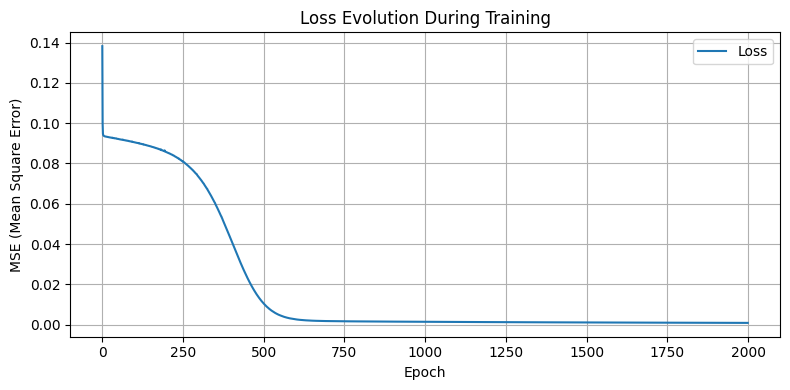

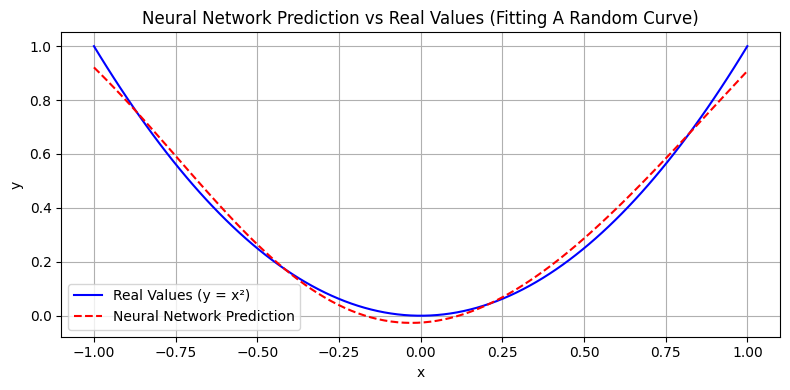

In [ ]:
# Datos inventados: y = x²
key = random.PRNGKey(0)
xx = jnp.linspace(-1, 1, 100).reshape(-1, 1)
yy = xx ** 2

# Inicializo y entreno
params_init = init_network_params(layer_sizes, key)

params_trained, loss_hist = update_sgd(
    init_params = params_init,
    x_data = xx,
    y_data = yy,
    n_epoches = 2000,
    tolerance = 1e-6,
    predict_function = predict_function,
    loss_function = loss_function,
    batch_size = 10,
    alpha = 0.01,
    imprimir = False
)

# Grafico la pérdida
plt.figure(figsize=(8, 4))
plt.plot(loss_hist, label = 'Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE (Mean Square Error)')
plt.title('Loss Evolution During Training')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Predicción final
predict_batch = jax.vmap(predict_function, in_axes=(None, 0))
y_pred = predict_batch(params_trained, xx)

# Grafico puntos reales vs curva de ajuste
plt.figure(figsize = (8, 4))
plt.plot(xx, yy, label = 'Real Values (y = x²)', color = 'blue')
plt.plot(xx, y_pred, label = 'Neural Network Prediction', color = 'red', linestyle = '--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Network Prediction vs Real Values (Fitting A Random Curve)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()